### 準線形モデルの時間反復法による数値解法

#### 最適裁量政策
モデルの均衡条件は以下で与えられる

\begin{align*}
   & R_{t} = -y_{t} + \mathbb{E}_{t}y_{t+1} + \mathbb{E}_{t}\pi_{t+1} + s_{t} \geq 0 \\
   & \pi_{t} = \kappa y_{t} + \beta \mathbb{E}_{t}\pi_{t+1} = 0 \\
   & \pi_{t} - \phi_{PC,t} = 0 \\ 
   & \lambda y_{t} + \kappa \phi_{PC,t} - \phi_{EE,t} = 0 \\ 
   & -\phi_{EE,t} + \phi_{ZLB,t} = 0 
\end{align*}

$(\beta,\kappa,\lambda,r^{*})$はモデルのパラメータ。定常状態での政策金利は、$r^{*}=(\beta^{-1}-1) \times 100$

$s_t\in\{s_{H},s_{L}\}$は以下の遷移行列を持つマルコフ連鎖にしたがう
\begin{align*}
    P = \left[\begin{array}{cc}
    1-p_{H} & p_{H}\\
    1-p_{L} & p_{L}
    \end{array}\right].
\end{align*}

- ここで、$\phi_{ZLB,t}$はゼロ金利制約にかかるラグランジュ乗数であり、ゼロ金利制約がバインドしない限りはゼロになる

- このことは以下の相補スラック条件にまとめられる

$$
  \phi_{ZLB,t} R_{t} = 0, \quad \phi_{ZLB,t} \geq 0, \quad R_{t} \geq 0
$$

- すなわち、$\phi_{ZLB,t} > 0$あるいは$R_{t} > 0$のいずれかが成り立ち、均衡条件は$R_{t}$の値によって場合分けされる

- 相補スラック条件より、もし$R_{t} > 0$であれば、$\phi_{ZLB,t} = 0$である。このとき均衡条件は、

\begin{align*}
  R_{t} &= -y_{t} + \mathbb{E}_{t}y_{t+1} + \mathbb{E}_{t}\pi_{t+1} + s_{t} \\
  \pi_{t} &= \kappa y_{t} + \beta \mathbb{E}_{t}\pi_{t+1} = 0 \\
  0 &= \lambda y_{t} + \kappa \pi_{t}
\end{align*}

- あるいは、もし$R_{t}=0$であれば、$\phi_{ZLB,t} = \phi_{EE,t} > 0$である。このとき均衡条件は、

\begin{align*}
  0 &= -y_{t} + \mathbb{E}_{t}y_{t+1} + \mathbb{E}_{t}\pi_{t+1} + s_{t} \\
  \pi_{t} &= \kappa y_{t} + \beta \mathbb{E}_{t}\pi_{t+1} = 0 \\
  \phi_{EE,t} &= \lambda y_{t} + \kappa \pi_{t}
\end{align*}

In [4]:
struct Model{TI<:Integer, TF<:AbstractFloat}
    β::TF       # 割引因子
    κ::TF       # フィリップス曲線の傾き
    λ::TF       # 社会厚生のうち産出ギャップにかかるウェイト
    rstar::TF   # pH=0のときの、定常状態での名目金利の値
    sH::TF      # 状態Hでの自然利子率の値
    sL::TF      # 状態Lでの自然利子率の値
    pH::TF      # 危機が起こる確率
    pL::TF      # 危機の継続確率
    maxiter::TI # 繰り返し回数の最大値
    tol::TF     # 許容誤差
end

### 解析的解

- ここで、

\begin{align*}
  \mathbb{E}_{t}y_{t+1} &= (1-p_{i})y_{H} + p_{i}y_{L} \\
  \mathbb{E}_{t}\pi_{t+1} &= (1-p_{i})\pi_{H} + p_{i}\pi_{L}
\end{align*}

をそれぞれの状態$i\in\{H,L\}$における均衡条件に代入すると、

\begin{align*}
  R_{H} &= -y_{H} + [(1-p_{H})y_{H} + p_{H}y_{L}] + [(1-p_{H})\pi_{H} + p_{H}\pi_{L}] + s_{H} \\
  \pi_{H} &= \kappa y_{H} + \beta [(1-p_{H})\pi_{H} + p_{H}\pi_{L}] \\
  0 &= \lambda y_{H} + \kappa \pi_{H} \\
  0 &= -y_{L} + [(1-p_{L})y_{H} + p_{L}y_{L}] + [(1-p_{L})\pi_{H} + p_{L}\pi_{L}] + s_{L} \\
  \pi_{L} &= \kappa y_{L} + \beta [(1-p_{L})\pi_{H} + p_{L}\pi_{L}] \\
  \phi_{EE,L} &= \lambda y_{L} + \kappa \pi_{L} \\
\end{align*}

6つの未知数に対して6つの線形の方程式があるため、未知数を解析的に求めることができる

In [58]:
function calcmpe(m)

    β = m.β
    κ = m.κ
    λ = m.λ
    rstar = m.rstar
    pH = m.pH
    pL = m.pL
    sH = m.sH
    sL = m.sL

    σ = 1.0
    invlam = 1.0/λ

    Ax = zeros(Float64,6,6)
    Ax[1,:] = [σ*pH -(1-pH) 1 -σ*pH -pH 0]
    Ax[2,:] = [-κ 1-β*(1-pH) 0 0 -β*pH 0]
    Ax[3,:] = [-1 -κ*invlam 0 0 0 0]
    Ax[4,:] = [-σ*(1-pL) -(1-pL) 0 σ*(1-pL) -pL 0]
    Ax[5,:] = [0 -β*(1-pL) 0 -κ 1-β*pL 0]
    Ax[6,:] = [0 0 0 -1 -κ*invlam -1]
    bx = zeros(Float64,6,1)
    bx[1] = sH
    bx[4] = sL
    xx = Ax\bx
    yh = xx[1]
    yl = xx[4]
    pih = xx[2]
    pil = xx[5]
    rh = xx[3]
    rl = 0.0

    Av = zeros(Float64,2,2)
    Av[1,:] = [1-β*(1-pH) -β*pH]
    Av[2,:] = [-β*(1-pL) 1-β*pL]
    bv = zeros(Float64,2,1)
    bv[1] = -yh^2 - invlam*pih^2
    bv[2] = -yl^2 - invlam*pil^2
    vv = Av\bv
    vh = vv[1]
    vl = vv[2]
    yvec0 = [yh yl]'
    pvec0 = [pih pil]'
    ivec0 = [rh rl]'
    vvec0 = [vh vl]'

    return yvec0, pvec0, ivec0, vvec0

end


calcmpe (generic function with 2 methods)

In [60]:
# ライブラリの読み込み
using NLsolve
using Interpolations

damp = 1.0

rstar = 0.75 # pH=0のときの、定常状態での名目金利の値
β = 0.9925 #1/(1+rstar/100) # 割引率(オイラー方程式の定常状態より)
κ = 0.01
λ = 0.003
pH = 0.0
pL = 0.8
sH = rstar
sL = rstar-2.5

maxiter = 2000 # 繰り返し回数の最大値
tol = 1e-5 # 許容誤差

# 構造体にパラメータを格納
m = Model(β,κ,λ,rstar,sH,sL,pH,pL,maxiter,tol)

# 最適裁量政策の解析解
yvec0, pvec0, ivec0, vvec0 = calcmpe(m)
println([yvec0[2] pvec0[2]])


[-10.858433734939764 -0.5271084337349401]


#### 最適コミットメント政策
モデルの均衡条件は以下で与えられる

\begin{align*}
   & R_{t} = -y_{t} + \mathbb{E}_{t}y_{t+1} + \mathbb{E}_{t}\pi_{t+1} + s_{t} \geq 0 \\
   & \pi_{t} = \kappa y_{t} + \beta \mathbb{E}_{t}\pi_{t+1} = 0 \\
   & \pi_{t} - \phi_{PC,t} + \phi_{PC,t-1} + \beta^{-1}\phi_{EE,t-1} = 0 \\ 
   & \lambda y_{t} + \kappa \phi_{PC,t} - \phi_{EE,t} + \beta^{-1}\phi_{EE,t-1} = 0 \\ 
   & -\phi_{EE,t} + \phi_{ZLB,t} = 0 
\end{align*}

- 相補スラック条件より、もし$R_{t} > 0$であれば、$\phi_{ZLB,t} = 0$である。このとき均衡条件は、

\begin{align*}
   & R_{t} = -y_{t} + \mathbb{E}_{t}y_{t+1} + \mathbb{E}_{t}\pi_{t+1} + s_{t} \\
   & \pi_{t} = \kappa y_{t} + \beta \mathbb{E}_{t}\pi_{t+1} = 0 \\
   & \pi_{t} - \phi_{PC,t} + \phi_{PC,t-1} + \beta^{-1}\phi_{EE,t-1} = 0 \\ 
   & \lambda y_{t} + \kappa \phi_{PC,t} + \beta^{-1}\phi_{EE,t-1} = 0
\end{align*}

- あるいは、もし$R_{t}=0$であれば、$\phi_{ZLB,t} = \phi_{EE,t} > 0$である。このとき均衡条件は、

\begin{align*}
   & 0 = -y_{t} + \mathbb{E}_{t}y_{t+1} + \mathbb{E}_{t}\pi_{t+1} + s_{t} \\
   & \pi_{t} = \kappa y_{t} + \beta \mathbb{E}_{t}\pi_{t+1} = 0 \\
   & \pi_{t} - \phi_{PC,t} + \phi_{PC,t-1} + \beta^{-1}\phi_{EE,t-1} = 0 \\ 
   & \lambda y_{t} + \kappa \phi_{PC,t} - \phi_{EE,t} + \beta^{-1}\phi_{EE,t-1} = 0
\end{align*}

### 時間反復法による数値解

### アルゴリズム

#### 1. グリッド生成
状態空間の評価点を有限個のグリッドに区切る
  - $(s_{H},s_{L})$はすでに与えられている
  - $\phi_{EE,-1,j}\in[0,\phi_{EE,-1,max}]$を$j=1,...,N$個のグリッド$(\phi_{EE,-1,1},\phi_{EE,-1,2},...,\phi_{EE,-1,N})$に分割
  - $\phi_{PC,-1,k}\in[-\phi_{PC,-1,min},\phi_{PC,-1,max}]$を$k=1,...,M$個のグリッド$(\phi_{PC,-1,1},\phi_{PC,-1,2},...,\phi_{PC,-1,N})$に分割

#### 2. 収束の基準
収束の基準になるパラメータ$\varepsilon>0$を与える


#### 3. 最適化および補間
古い政策関数

$$
y = \varsigma_{y}^{(n-1)}(\phi_{EE,-1},\phi_{PC,-1},s), \quad \pi = \varsigma_{\pi}^{(n-1)}(\phi_{EE,-1},\phi_{PC,-1},s)
$$

およびそれぞれのグリッドにおける$(\color{blue}{\phi_{EE,-1,j},\phi_{PC,-1,k},s_{i}})$の値を所与として、$R_{i,j,k} > 0$および$\phi_{EE,i,j,k}=0$と仮定したとき、以下の式を$(\color{magenta}{y_{i,j,k},\pi_{i,j,k},R_{i,j,k},\phi_{PC,i,j,k}})$について解く

\begin{align*}
   & \color{magenta}{R_{i,j,k}} = -\color{magenta}{y_{i,j,k}} + y_{i}^{e}(0,\color{magenta}{\phi_{PC,i,j,k}}) + \pi_{i}^{e}(0,\color{magenta}{\phi_{PC,i,j,k}}) + \color{blue}{s_{i}} \\
   & \color{magenta}{\pi_{i,j,k}} = \kappa \color{magenta}{y_{i,j,k}} + \beta \pi_{i}^{e}(0,\color{magenta}{\phi_{PC,i,j,k}}) \\
   & \color{magenta}{\pi_{i,j,k}} - \color{magenta}{\phi_{PC,i,j,k}} + \color{blue}{\phi_{PC,-1,k}} + \beta^{-1}\color{blue}{\phi_{EE,-1,j}} = 0 \\ 
   & \color{magenta}{\lambda y_{i,j,k}} + \kappa \color{magenta}{\phi_{PC,i,j,k}} + \beta^{-1}\color{blue}{\phi_{EE,-1,j}} = 0
\end{align*}

ゼロ点を数値的に解く最適化アルゴリズム（ニュートン法など）を用いる

ここで$R_{i,j,k}<0$が得られた場合、$R_{i,j,k} = 0$および$\phi_{EE,i,j,k}>0$と仮定して、以下の式を$(\color{magenta}{y_{i,j,k},\pi_{i,j,k},\phi_{EE,i,j,k},\phi_{PC,i,j,k}})$について解く

\begin{align*}
   & 0 = -\color{magenta}{y_{i,j,k}} + y_{i}^{e}(\color{magenta}{\phi_{EE,i,j,k},\phi_{PC,i,j,k}}) + \pi_{i}^{e}(\color{magenta}{\phi_{EE,i,j,k},\phi_{PC,i,j,k}}) + \color{blue}{s_{i}} \\
   & \color{magenta}{\pi_{i,j,k}} = \kappa \color{magenta}{y_{i,j,k}} + \beta \pi_{i}^{e}(\color{magenta}{\phi_{EE,i,j,k},\phi_{PC,i,j,k}}) \\
   & \color{magenta}{\pi_{i,j,k}} - \color{magenta}{\phi_{PC,i,j,k}} + \color{blue}{\phi_{PC,-1,k}} + \beta^{-1}\color{blue}{\phi_{EE,-1,j}} = 0 \\ 
   & \color{magenta}{\lambda y_{i,j,k}} + \kappa \color{magenta}{\phi_{PC,i,j,k}} - \color{magenta}{\phi_{EE,i,j,k}} + \beta^{-1}\color{blue}{\phi_{EE,-1,j}} = 0
\end{align*}

ここで、$y_{i}^{e}(\color{magenta}{\phi_{EE,i,j,k},\phi_{PC,i,j,k}}),\pi_{i}^{e}(\color{magenta}{\phi_{EE,i,j,k},\phi_{PC,i,j,k}})$は$(\color{magenta}{\phi_{EE,i,j,k},\phi_{PC,i,j,k}})$の非線形な関数

\begin{align*}
  y_{i}^{e}(\color{magenta}{\phi_{EE,i,j,k},\phi_{PC,i,j,k}}) &= (1-p_{i})\varsigma_{y}^{(n-1)}(\color{magenta}{\phi_{EE,i,j,k},\phi_{PC,i,j,k}},s_{H}) + p_{i}\varsigma_{y}^{(n-1)}(\color{magenta}{\phi_{EE,i,j,k},\phi_{PC,i,j,k}},s_{L}) \\
  \pi_{i}^{e}(\color{magenta}{\phi_{EE,i,j,k},\phi_{PC,i,j,k}}) &= (1-p_{i})\varsigma_{\pi}^{(n-1)}(\color{magenta}{\phi_{EE,i,j,k},\phi_{PC,i,j,k}},s_{H}) + p_{i}\varsigma_{\pi}^{(n-1)}(\color{magenta}{\phi_{EE,i,j,k},\phi_{PC,i,j,k}},s_{L})
\end{align*}

である。$(\color{magenta}{\phi_{EE,i,j,k},\phi_{PC,i,j,k}})$はグリッド上にあるとは限らないので、$\varsigma^{(n-1)}(\color{blue}{\phi_{EE,-1,j},\phi_{PC,-1,k},s_{i}})$の値から補間する必要がある

このステップで、新しい政策関数のベクトル$\varsigma^{(n)}(\phi_{EE,-1,j},\phi_{PC,-1,k},s_{i})$

$$
  (y_{H,1,1}^{(n)},y_{H,2,1}^{(n)},...,y_{H,N,1}^{(n)},y_{H,1,2}^{(n)},...,y_{H,N,2}^{(n)},...,y_{H,1,M}^{(n)},...,y_{H,N,M}^{(n)} \\
  y_{L,1,1}^{(n)},y_{L,2,1}^{(n)},...,y_{L,N,1}^{(n)},y_{L,1,2}^{(n)},...,y_{L,N,2}^{(n)},...,y_{L,1,M}^{(n)},...,y_{L,N,M}^{(n)}) \\
  (\pi_{H,1,1}^{(n)},\pi_{H,2,1}^{(n)},...,\pi_{H,N,1}^{(n)},\pi_{H,1,2}^{(n)},...,\pi_{H,N,2}^{(n)},...,\pi_{H,1,M}^{(n)},...,\pi_{H,N,M}^{(n)} \\
  \pi_{L,1,1}^{(n)},\pi_{L,2,1}^{(n)},...,\pi_{L,N,1}^{(n)},\pi_{L,1,2}^{(n)},...,\pi_{L,N,2}^{(n)},...,\pi_{L,1,M}^{(n)},...,\pi_{L,N,M}^{(n)}) \\
$$

を得る

#### 4. 収束の判定
全ての$(\phi_{EE,-1,j},\phi_{PC,-1,k},s_{i})$について$\|\varsigma^{(n)}(\phi_{EE,-1,j},\phi_{PC,-1,k},s_{i})-\varsigma^{(n-1)}(\phi_{EE,-1,j},\phi_{PC,-1,k},s_{i})\|<\varepsilon$であればストップ。そうでなければ、$\varsigma^{(n)}(\phi_{EE,-1,j},\phi_{PC,-1,k},s_{i})$を$\varsigma^{(n-1)}(\phi_{EE,-1,j},\phi_{PC,-1,k},s_{i})$に代入して、ステップ3-4を繰り返す

In [49]:
# time iterationを行う関数
function ti(m,mmin,mmax,nmin,nmax,nm,nn,ns,damp)

    β = m.β
    κ = m.κ
    λ = m.λ
    rstar = m.rstar
    pH = m.pH
    pL = m.pL
    sH = m.sH
    sL = m.sL
    
    σ = 1.0
    invlam = 1.0/λ

    Gs = [sH; sL]
    Ps = [1.0-pH pH; 1.0-pL pL]

    knotsm = range(mmin,stop=mmax,length=nm)
    knotsn = exp10.(range(log(1.0)/log(10.0),stop=log(nmax-nmin+1.0)/log(10.0),length=nn))
    knotsn = knotsn .+ (nmin - 1.0)

    ## STEP 1.b: 政策関数の初期値を当て推量
    # 適当な初期値
    ymat0 = zeros(Float64,nm,nn,ns)
    pmat0 = zeros(Float64,nm,nn,ns)
    imat0 = zeros(Float64,nm,nn,ns)
    mmat0 = zeros(Float64,nm,nn,ns)
    nmat0 = zeros(Float64,nm,nn,ns)
    vmat0 = zeros(Float64,nm,nn,ns)

    ymat1 = copy(ymat0)
    pmat1 = copy(pmat0)
    imat1 = copy(imat0)
    mmat1 = copy(mmat0)
    nmat1 = copy(nmat0)
    vmat1 = copy(vmat0)

    ymat1 = copy(ymat0)
    pmat1 = copy(pmat0)
    imat1 = copy(imat0)
    mmat1 = copy(mmat0)
    nmat1 = copy(nmat0)

    ## STEP 4: 政策関数を繰り返し計算
    diff = 1e+4
    iter = 0

    while (diff>m.tol && iter<m.maxiter)

        ## STEP 3: 各グリッドごとに最適化
        @inbounds for is in 1:ns

            # ショックの値
            s0 = Gs[is]

            # 古い政策関数から期待値(ye,pie)を計算
            eyvec = zeros(Float64,nm,nn)
            epvec = zeros(Float64,nm,nn)
            evvec = zeros(Float64,nm,nn)

            @inbounds for js in 1:ns

                eyvec = eyvec + Ps[is,js]*ymat0[:,:,js]
                epvec = epvec + Ps[is,js]*pmat0[:,:,js]
                evvec = evvec + Ps[is,js]*vmat0[:,:,js]

            end

            # 期待値はm_{t}の関数：m_{t}は必ずしもグリッド上にあるとは限らないため、補間する
            eyintp = LinearInterpolation((knotsm,knotsn),eyvec,extrapolation_bc=Line())
            epintp = LinearInterpolation((knotsm,knotsn),epvec,extrapolation_bc=Line())
            evintp = LinearInterpolation((knotsm,knotsn),evvec,extrapolation_bc=Line())

            @inbounds for im in 1:nm

                mpast = knotsm[im]

                @inbounds for in in 1:nn

                    npast = knotsn[in]

                    res = nlsolve(x->foc2(x,s0,mpast,npast,eyintp,epintp,β,κ,invlam,σ,rstar),[mpast])
                    m0 = res.zero[1]
                    n0 = 0.0

                    ey0 = eyintp(m0,n0)
                    ep0 = epintp(m0,n0)
                    y0 = (1.0/β)*npast - κ*m0
                    p0 = κ*y0 + β*ep0
                    i0 = σ*(ey0-y0) + ep0 + s0

                    if (i0<=0.0)

                        res = nlsolve(x->focr2(x,s0,mpast,npast,eyintp,epintp,β,κ,invlam,σ,rstar),[mpast,npast])
                        m0 = res.zero[1]
                        n0 = res.zero[2]

                        ep0 = epintp(m0,n0)
                        y0 = -n0 + (1.0/β)*npast - κ*m0
                        p0 = κ*y0 + β*ep0
                        i0 = 0.0

                    end

                    v0 = -y0^2 - invlam*p0^2 + β*evintp(m0,n0)

                    # 新しい政策関数を保存
                    ymat1[im,in,is] = y0
                    pmat1[im,in,is] = p0
                    imat1[im,in,is] = i0
                    mmat1[im,in,is] = m0
                    nmat1[im,in,is] = n0
                    vmat1[im,in,is] = v0

                end

            end

        end

        # 繰り返し計算誤差を確認
        ydiff = maximum(abs.(ymat1-ymat0))
        pdiff = maximum(abs.(pmat1-pmat0))
        vdiff = maximum(abs.(vmat1-vmat0))
        diff = maximum([ydiff pdiff vdiff])

        println([iter ydiff pdiff vdiff])

        # 政策関数をアップデート
        ymat0 = damp*ymat1 + (1.0-damp)*ymat0
        pmat0 = damp*pmat1 + (1.0-damp)*pmat0
        imat0 = damp*imat1 + (1.0-damp)*imat0
        mmat0 = damp*mmat1 + (1.0-damp)*mmat0
        nmat0 = damp*nmat1 + (1.0-damp)*nmat0
        vmat0 = damp*vmat1 + (1.0-damp)*vmat0

        iter = iter + 1
        
    end

    return ymat0, pmat0, imat0, mmat0, nmat0, vmat0

end


ti (generic function with 1 method)

In [50]:
function foc2(x,s0,mpast,npast,eyintp,epintp,β,κ,invlam,σ,rstar)

    m0 = x[1]
    n0 = 0.0

    ey0 = eyintp(m0,n0)
    ep0 = epintp(m0,n0)

    y0 = (1.0/β)*npast - κ*m0
    p0 = κ*y0 + β*ep0 # if kap=0 and ep=0, p0=0

    f = -invlam*p0 + (1.0/β/σ)*npast + m0 - mpast

    return f

end

function focr2(x,s0,mpast,npast,eyintp,epintp,β,κ,invlam,σ,rstar)

    m0 = x[1]
    n0 = x[2]

    ey0 = eyintp(m0,n0)
    ep0 = epintp(m0,n0)

    y0 = -n0 + (1.0/β)*npast - κ*m0
    p0 = κ*y0 + β*ep0 # if kap=0 and ep=0, p0=0
#     i0 = -rstar
    i0 = 0.0

    f = zeros(2)
    f[1] = -invlam*p0 + (1.0/β/σ)*npast + m0 - mpast
    f[2] = -y0 + ey0 - (1.0/σ)*(i0-ep0-s0)

    return f

end


focr2 (generic function with 1 method)

In [51]:
# policy function iteration
ns = 2
nm = 21
nn = 21
mmax = 0.0
mmin = -200.0
nmax = 50.0
nmin = 0.0

knotsm = range(mmin,stop=mmax,length=nm)
knotsn = exp10.(range(log(1.0)/log(10.0),stop=log(nmax-nmin+1.0)/log(10.0),length=nn))
knotsn = knotsn .+ (nmin - 1.0)

@time ymat0, pmat0, imat0, mmat0, nmat0, vmat0 = ti(m,mmin,mmax,nmin,nmax,nm,nn,ns,damp)

[0.0 1.7500000001702498 0.017500000001702497 3.16458333394907]
[1.0 1.2625000023722706 0.025031250024017335 9.141599298681]
[2.0 0.8755212539430115 0.02564880316417687 14.73031013188455]
[3.0 0.7951500471972097 0.030413062622217324 18.678309563437992]
[4.0 0.825563109875509 0.03844059574938137 20.749505822328402]
[5.0 0.8640037057257799 0.046792328335655095 31.02443069652378]
[6.0 0.9107960342584605 0.05554934620714272 47.284021121794595]
[7.0 0.966345382585116 0.0647961799258881 69.57734635725589]
[8.0 1.0311415649518283 0.07462162421419749 99.65848892026952]
[9.0 0.9873566665279467 0.07600488048840415 123.48541278721132]
[10.0 0.8285333776190824 0.06706321624097211 59.979554872405515]
[11.0 0.7989943950577962 0.06754295940811803 58.92647958551322]
[12.0 0.6503005099746493 0.05645098148880831 43.16374697533064]
[13.0 0.5010492543132803 0.04400801256486481 28.856118423994815]
[14.0 0.37264228274676436 0.0328869339430507 18.103603053114]
[15.0 0.26077644373406006 0.023003310575510916 9.

([1.672314640245998 1.886932148481952 … 8.06438317436265 8.804108527233497; 1.5886989082338578 1.8033164164730686 … 8.010233803014982 8.75156199806291; … ; 0.08361573201196049 0.2982332402513198 … 7.030615870657652 7.802744854227277; 0.0 0.21461750823912568 … 6.9760429395344925 7.749919063741072]

[-3.171325936487799 -3.148667397603726 … 0.005904970928760855 0.6006471066912451; -3.2275729274712646 -3.2048479616378254 … -0.04307135390877015 0.552224619032198; … ; -4.251225925133526 -4.2258476073503815 … -0.9268255300335226 -0.32166722516420876; -4.3086857275618495 -4.28321168724474 … -0.9760076543416152 -0.37031820521395586], [0.09830560792717134 0.10024344633682933 … 0.3720533147502591 0.4252521419317824; 0.09339032753097012 0.09532816594080971 … 0.36738769329434495 0.42062448498009075; … ; 0.0049152803963307765 0.006853118806180468 … 0.28329711404975927 0.3372511620404735; 0.0 0.0019378384098359567 … 0.2786220553840108 0.3326164210906891]

[0.054592363937073764 0.05591904134479657 … 0

### 結果のプロット

In [61]:
yintp = Array{Interpolations.Extrapolation}(undef,2)
pintp = Array{Interpolations.Extrapolation}(undef,2)
iintp = Array{Interpolations.Extrapolation}(undef,2)
mintp = Array{Interpolations.Extrapolation}(undef,2)
nintp = Array{Interpolations.Extrapolation}(undef,2)
vintp = Array{Interpolations.Extrapolation}(undef,2)

@inbounds for is in 1:ns

    yintp[is] = LinearInterpolation((knotsm,knotsn),ymat0[:,:,is],extrapolation_bc=Line())
    pintp[is] = LinearInterpolation((knotsm,knotsn),pmat0[:,:,is],extrapolation_bc=Line())
    iintp[is] = LinearInterpolation((knotsm,knotsn),imat0[:,:,is],extrapolation_bc=Line())
    mintp[is] = LinearInterpolation((knotsm,knotsn),mmat0[:,:,is],extrapolation_bc=Line())
    nintp[is] = LinearInterpolation((knotsm,knotsn),nmat0[:,:,is],extrapolation_bc=Line())
    vintp[is] = LinearInterpolation((knotsm,knotsn),vmat0[:,:,is],extrapolation_bc=Line())

end

# simulation
T = 40
T1 = 8
svec = ones(Float64,T+1)
ycvec = zeros(Float64,T+1)
pcvec = zeros(Float64,T+1)
icvec = zeros(Float64,T+1)
mcvec = zeros(Float64,T+1)
ncvec = zeros(Float64,T+1)
ydvec = zeros(Float64,T+1)
pdvec = zeros(Float64,T+1)
idvec = zeros(Float64,T+1)

svec[1:T1] = 2*ones(T1)

@inbounds for t in 1:T

    is = Int64(svec[t])
#     s0 = Gs[is]
    mpast = mcvec[t]
    npast = ncvec[t]
        
    ycvec[t+1] = yintp[is](mpast,npast)
    pcvec[t+1] = pintp[is](mpast,npast)
    icvec[t+1] = iintp[is](mpast,npast)
    mcvec[t+1] = mintp[is](mpast,npast)
    ncvec[t+1] = nintp[is](mpast,npast)
    ydvec[t+1] = yvec0[is]
    pdvec[t+1] = pvec0[is]
    idvec[t+1] = ivec0[is]

end

ycvec = ycvec[2:T+1]
pcvec = pcvec[2:T+1]
icvec = icvec[2:T+1]
mcvec = mcvec[2:T+1]
ncvec = ncvec[2:T+1];
ydvec = ydvec[2:T+1]
pdvec = pdvec[2:T+1]
idvec = idvec[2:T+1];

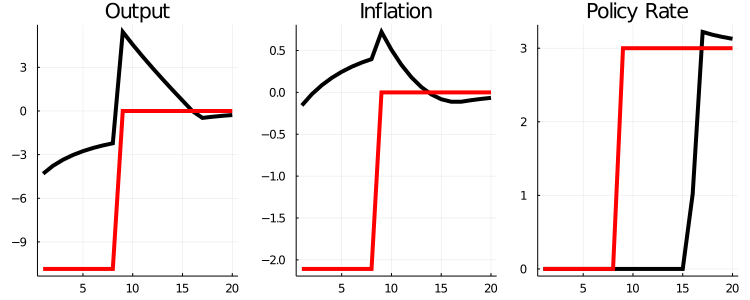

In [62]:
using Plots

Tshow = 20
plot(
    plot([ycvec[1:Tshow],ydvec[1:Tshow]],title="Output",color=[:black :red],legend=false),
    plot([pcvec[1:Tshow],pdvec[1:Tshow]]*4,title="Inflation",color=[:black :red],legend=false),
    plot([icvec[1:Tshow],idvec[1:Tshow]]*4,title="Policy Rate",color=[:black :red],legend=false),
    layout=(1,3),size=(750,300),linewidth=4)